# Quora Question Pair Similarity


## Himanshu Patel (204101029)
## M.Tech Computer Science and Engineering, IIT Guwahati


# 1. Exploratory Data Analysis

In [1]:
!pip3 install distance
!pip3 install fuzzywuzzy

In [2]:
# importing required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from os import path
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



### 1.1 Reading Data 

In [3]:
# mounting drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_csv('/content/drive/My Drive/ML_Projects/train.csv')
data.shape

(404290, 6)

In [5]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


So we have 404K data points ans each data point is 6 dimensional.
Each data point have following features
1. ID : unique id for each row
2. qid1 : unique id for each question1
3. qid2 : unique id for each question2
4. question1 : text of question1
5. question2 : text of question2
6. is_duplicate : this is the label, 0 -> questions are duplicate, 1 -> not duplicate.

So we have very few features.

### 1.2 Distribution of data points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



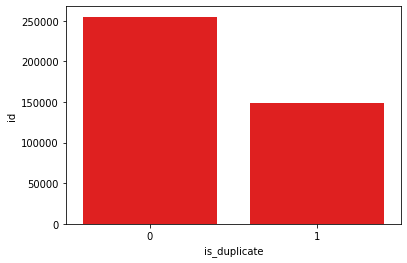

In [7]:
distribution = data.groupby("is_duplicate")['id'].count()
sns.barplot(['0','1'], distribution, color='red')
plt.xlabel("is_duplicate")
plt.show()

In [8]:
not_similar = data.groupby("is_duplicate")['id'].count()[0]
similar = data.groupby("is_duplicate")['id'].count()[1]

print("No of data points with non similar questions : ", not_similar)
print("No of data points with similar questions : ", similar)

No of data points with non similar questions :  255027
No of data points with similar questions :  149263


### 1.3 Number of unique questions

In [9]:
qids = pd.Series(data["qid1"].tolist() + data["qid2"].tolist())

unique_qids = len(np.unique(qids))

repeated_qids = np.sum(qids.value_counts() > 1)

print("No of unique questions : ", unique_qids)
print("No of repeated questions : ", repeated_qids)

No of unique questions :  537933
No of repeated questions :  111780


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



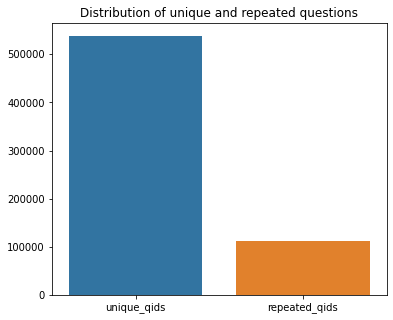

In [10]:
x = ['unique_qids', 'repeated_qids']
y = [unique_qids, repeated_qids]

plt.figure(figsize=(6,5))
plt.title("Distribution of unique and repeated questions")
sns.barplot(x,y)
plt.show()

### 1.4 Checking for Duplicate rows

In [11]:
duplicate_rows = data[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

print("No of duplicate rows : ", duplicate_rows.shape[0] - data.shape[0])

No of duplicate rows :  0


### 1.5 Checking Null values

In [12]:
null_rows = data[data.isnull().any(1)]
print(null_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


There are 3 rows with null or NAN values we need to remove them.

In [13]:
data = data.fillna('')
null_rows = data[data.isnull().any(1)]
print(null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### 1.6 Preprocessing

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
#This functions accepts a raw question and perform preprocessing on it and then returns clean question.


def preprocess(q):
  # Firstly, we convert to lowercase and remove trailing and leading spaces
  q = str(q).lower().strip()

  # Replace certain special characters with their string equivalents
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')

  # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
  q = q.replace(',000,000,000 ', 'b ')
  q = q.replace(',000,000 ', 'm ')
  q = q.replace(',000 ', 'k ')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)

  # Decontracting words
  # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  # https://stackoverflow.com/a/19794953
  contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
  }

  q_decontracted = []

  for word in q.split():
    if word in contractions:
      word = contractions[word]
  
    q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  # Removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()

  # Remove punctuations
  pattern = re.compile('\W')   # \W means any word character which includes a-z, A-Z, 0-9, _ (underscore)
  q = re.sub(pattern, ' ', q).strip()

  return q


### 1.7 Extracting Features

As we have only 6 features in our dataset. We need some more features.
I have broadly classified the features in 3 categories as follows :

1. Token Features
    * q1_len: Number of characters in question1
    * q2_len: Number of characters in question2
    * q1_words: Number of words in question1
    * q2_words: Number of words in question2
    * words_total: Sum of q1_words and q2_words
    * words_common: Number of words which occur in question1 and question2, repeated occurences are not counted.
    * words_shared: Fraction of words_common to words_total
    * cwc_min: This is the ratio of the number of common words to the length of smaller questions
    * cwc_max: This is the ration of the number of common words to the length of larger question
    * csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
    * csc_max: This is the ratio of the number of common stop words to the smaller larger stop word count amont the two questions.
    * ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
    * ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions.
    * last_word_eq: 1 if the last word in two questions is same, 0 otherwise
    * first_word_eq: 1 if the first word in two questions is same, 0 otherwise


2. Fuzzy Features
    * fuzz_ratio: fuzz_ratio score from fuzzywuzzy
    * fuzz_partail_ratio: fuzz_partial_ratio from fuzzywuzzy
    * token_sort_ratio: token_sort_ratio from fuzzywuzzy
    * token_set_ratio: token_set_ratio from fuzzywuzzy

    
3. Length Features
    * mean_len: Mean of the length of the two questions(number of words)
    * abs_len_diff: Absoulte difference between the length of the two questions
    * longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

In [16]:
# Receives question1 and question2 from one row in DataFrame
# Computes token features, removes stopwords and performs stemming
# Returns an array of shape (num_features,)
def get_token_features(q1, q2):
  # Safe div to avoid division by 0 exception
  safe_div = 0.0001

  # Getting NLTK  stop words set
  stop_words = stopwords.words('english')

  # Initializing stemmer
  stemmer = PorterStemmer()

  # Initializing feature array
  token_features = [0.0] * 15

  # Tokenizing
  q1 = q1.split()
  q2 = q2.split()

  # Stop words in q1 and q2
  q1_stops = set([word for word in q1 if word in stop_words])
  q2_stops = set([word for word in q2 if word in stop_words])
  common_stops = q1_stops & q2_stops

  # Removing stop words
  q1 = [word for word in q1 if word not in stop_words]
  q2 = [word for word in q2 if word not in stop_words]

  # Stem
  # Is redundant but this design change was made much later and 
  # I don't feel like changing the entire function for it.
  # For now, computationally inefficient though it may be, it will do.
  q1_stemmed = ' '.join([word for word in q1])
  q2_stemmed = ' '.join([word for word in q2])

  if len(q1) == 0 or len(q2) == 0:
    return (token_features, q1_stemmed, q2_stemmed)

 
  # We do this here because converting to set looses order of words
  # last_word_eq
  token_features[13] = int(q1[-1] == q2[-1])

  # first_word_eq
  token_features[14] = int(q1[0] == q2[0])

  # Now we convert the questions into sets, this looses order but removes duplicate words
  q1 = set(q1)
  q2 = set(q2)
  common_tokens = q1 & q2

  # Sets are still iterables, order of words won't change the number of characters
  # q1_len
  token_features[0] = len(q1_stemmed) * 1.0

  # q2_len
  token_features[1] = len(q2_stemmed) * 1.0

  # q1_words
  token_features[2] = len(q1) * 1.0

  # q2_words
  token_features[3] = len(q2) * 1.0

  # words_total
  token_features[4] = token_features[2] + token_features[3]

  # Common words
  q1_words = set(q1)
  q2_words = set(q2)
  common_words = q1_words & q2_words
  
  # words_common
  token_features[5] = len(common_words) * 1.0
  # words_shared
  token_features[6] = token_features[5] / (token_features[4] + safe_div)

  # cwc_min
  token_features[7] = token_features[5] / (min(token_features[2], token_features[3]) + safe_div)

  # cwc_max
  token_features[8] = token_features[5] / (max(token_features[2], token_features[3]) + safe_div)

  # csc_min
  token_features[9] = (len(common_stops) * 1.0) / (min(len(q1_stops), len(q2_stops)) + safe_div)

  # csc_max
  token_features[10] = (len(common_stops) * 1.0) / (max(len(q1_stops), len(q2_stops)) + safe_div)

  # ctc_min
  token_features[11] = (len(common_tokens) * 1.0) / (min(len(q1), len(q2)) + safe_div)

  # ctc_max
  token_features[12] = (len(common_tokens) * 1.0) / (max(len(q1), len(q2)) + safe_div) 

  return (token_features, q1_stemmed, q2_stemmed)


# Computes fuzzy features
# Returns an array of shape (n_features,)
def get_fuzzy_features(q1, q2):
  # Initilzing feature array
  fuzzy_features = [0.0] * 4

  # fuzz_ratio
  fuzzy_features[0] = fuzz.QRatio(q1, q2)

  # fuzz_partial_ratio
  fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

  # token_sort_ratio
  fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

  # token_set_ratio
  fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

  return fuzzy_features

# Computes length features
# Returns an array of shape (n_features,)
def get_length_features(q1, q2):
  # Safe div to avoid division by 0 exception
  safe_div = 0.0001

  # Initialzing feature array
  length_features = [0.0] * 3

  q1_list = q1.strip(' ')
  q2_list = q2.strip(' ')

  # mean_len
  length_features[0] = (len(q1_list) + len(q2_list)) / 2

  # abs_len_diff
  length_features[1] = abs(len(q1_list) - len(q2_list))

  # Get substring length
  substr_len = distance.lcsubstrings(q1, q2, positions=True)[0]

  # longest_substr_ratio
  if substr_len == 0:
    length_features[2] = 0
  else:
    length_features[2] = substr_len / (min(len(q1_list), len(q2_list)) + safe_div)

  return length_features



# Receives data set and performs cleaning, feature extractions
# Transforms data set by adding feature columns
# Returns transformed DataFrame
def extract_features(data):
  # First, lets call the preprocess function on question1 and question2
  data['question1'] = data['question1'].apply(preprocess)
  data['question2'] = data['question2'].apply(preprocess)

  # Get token features, token_features is an array of shape (n_rows, data)
  # where data is a tuple of containing (n_features, q1_stemmed, q2_stemmed)
  # token_features, q1_stemmed, q2_stemmed = data.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
  token_features = data.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
  
  q1_stemmed = list(map(lambda x: x[1], token_features))
  q2_stemmed = list(map(lambda x: x[2], token_features))
  token_features = list(map(lambda x: x[0], token_features))

  data['question1'] = q1_stemmed
  data['question2'] = q2_stemmed

  # Creating new feature columns for token features
  data['q1_len'] = list(map(lambda x: x[0], token_features))
  data['q2_len'] = list(map(lambda x: x[1], token_features))
  data['q1_words'] = list(map(lambda x: x[2], token_features))
  data['q2_words'] = list(map(lambda x: x[3], token_features))
  data['words_total'] = list(map(lambda x: x[4], token_features))
  data['words_common'] = list(map(lambda x: x[5], token_features))
  data['words_shared'] = list(map(lambda x: x[6], token_features)) 
  data['cwc_min'] = list(map(lambda x: x[7], token_features))
  data['cwc_max'] = list(map(lambda x: x[8], token_features))
  data['csc_min'] = list(map(lambda x: x[9], token_features))
  data['csc_max'] = list(map(lambda x: x[10], token_features))
  data['ctc_min'] = list(map(lambda x: x[11], token_features))
  data['ctc_max'] = list(map(lambda x: x[12], token_features))
  data['last_word_eq'] = list(map(lambda x: x[13], token_features))
  data['first_word_eq'] = list(map(lambda x: x[14], token_features))
  

  # Get fuzzy features, fuzzy_features is an array of shape (n_rows, n_features)
  fuzzy_features = data.apply(lambda x: get_fuzzy_features(x['question1'], x['question2']), axis=1)
  # Creating new feature columns for fuzzy features
  data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
  data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
  data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
  data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

  # Get length features, length_features is an array of shape (n_rows, n_features)
  length_features = data.apply(lambda x: get_length_features(x['question1'], x['question2']), axis=1)

  # Creating new feature columns for length features
  data['mean_len'] = list(map(lambda x: x[0], length_features))
  data['abs_len_diff'] = list(map(lambda x: x[1], length_features))
  data['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

  return data


In [18]:
if os.path.isfile('/content/drive/My Drive/ML_Projects/Cleaned_featured_data.csv') :
  data = pd.read_csv('/content/drive/My Drive/ML_Projects/Cleaned_featured_data.csv')
else:
  data = extract_features(data)
  data.to_csv('/content/drive/My Drive/ML_Projects/Cleaned_featurized_train.csv', index=False)
  

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.



In [19]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,words_total,words_common,words_shared,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,mean_len,abs_len_diff,longest_substr_ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41.0,35.0,6.0,5.0,11.0,5.0,0.454541,0.999980,0.833319,0.999983,0.999983,0.999980,0.833319,0.0,1.0,92,100,92,100,38.0,6,0.999997
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,31.0,67.0,5.0,10.0,15.0,4.0,0.266665,0.799984,0.399996,0.749981,0.599988,0.799984,0.399996,0.0,0.0,59,94,59,89,49.0,36,0.838707
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44.0,36.0,6.0,5.0,11.0,2.0,0.181817,0.399992,0.333328,0.399992,0.249997,0.399992,0.333328,0.0,0.0,55,46,65,65,40.0,8,0.249999
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,21.0,44.0,3.0,6.0,9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,22,24,18,22,32.5,23,0.047619
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60.0,29.0,10.0,5.0,15.0,2.0,0.133332,0.399992,0.199998,0.999950,0.666644,0.399992,0.199998,0.0,0.0,25,52,40,51,44.5,31,0.206896


### 1.8 Pair plots of ctc_min , cwc_min , csc_min , token_sort_ratio

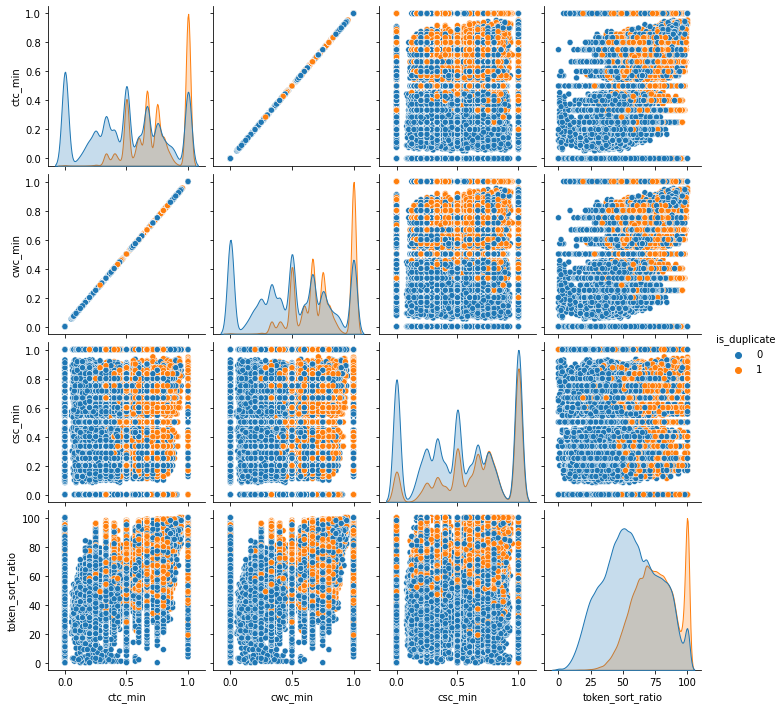

In [20]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

### 1.9 TF-IDF weighted Word2Vec

In [21]:
df = pd.read_csv('/content/drive/My Drive/ML_Projects/train.csv')
df['question1'] = df['question1'].apply(lambda x : str(x))
df['question2'] = df['question2'].apply(lambda x : str(x))

In [22]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [23]:
questions = list(df['question1'] + df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [24]:
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
if not os.path.isfile('/content/drive/My Drive/ML_Projects/final_features.csv'):
    for qu1 in tqdm(list(df['question1'])):
        doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
        # word2vec
            vec1 = word1.vector
        # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
        # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [1:13:20<00:00, 91.88it/s]


In [25]:
vecs2 = []
if not os.path.isfile('/content/drive/My Drive/ML_Projects/final_features.csv'):
    for qu2 in tqdm(list(df['question2'])):
        doc2 = nlp(qu2) 
        mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
        for word2 in doc2:
        # word2vec
            vec2 = word2.vector
        # fetch df score
            try:
                idf = word2tfidf[str(word2)]
            except:
            #print word
                idf = 0
        # compute final vec
            mean_vec2 += vec2 * idf
        mean_vec2 = mean_vec2.mean(axis=0)
        vecs2.append(mean_vec2)
    df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:14:24<00:00, 90.55it/s]


In [40]:
q1_w2v = pd.DataFrame(vecs1, index = df.index)
q2_w2v = pd.DataFrame(vecs2, index = df.index)

q1_w2v.head()
q2_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-13.620380,55.174406,-49.319319,19.330430,105.071882,95.487952,4.580482,60.383877,32.447365,193.267669,-14.582099,5.418994,41.382358,-91.207269,-0.916440,-62.264272,-27.105924,-13.939574,-26.434010,32.218971,61.319239,49.238942,2.027565,24.731739,-43.467814,-24.991492,47.540203,-21.465071,91.337835,-88.181354,118.727001,-26.868957,79.637464,-85.749049,-21.959341,-64.240128,161.348932,-58.661286,-22.215173,-55.272680,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,-4.573392,-17.256641,-124.454872,3.755200,74.546380,25.356515,71.846558,80.378516,122.806256,265.261163,51.570208,-46.904851,120.690118,-102.457597,-35.554424,-112.863932,20.321423,75.885814,-29.905485,-80.558056,-69.502619,-13.014798,-51.993633,-79.722704,-114.806221,-25.244660,36.639888,-114.827419,93.512770,-162.206798,64.752525,47.786181,0.411106,-85.053363,-4.323911,-159.520749,232.990250,-101.105357,-112.632742,-77.503579,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,145.936378,53.856403,-7.778189,29.571679,125.629409,104.972918,81.873991,17.806780,22.781358,159.625735,-97.162565,-24.805664,-41.250886,-90.539940,-11.489335,40.869229,18.981395,15.190094,1.035231,-26.410903,-11.395086,10.098930,-47.132079,-4.011681,8.820199,17.276955,-35.304112,-12.248830,42.051355,-100.426170,117.256485,0.368151,36.947805,-48.137193,36.439087,-75.182259,115.434736,-63.299879,-99.413246,-19.000230,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,38.731400,53.918078,27.807450,-4.834872,28.846942,76.957113,12.732388,37.050292,22.167618,94.674374,-65.086883,-59.556512,-17.430423,-52.775955,-4.152630,22.888613,-34.319802,-4.656021,13.143495,13.187962,30.767932,-34.760463,-18.181841,-6.447487,-29.351979,26.148819,-40.399859,-62.816427,36.736716,2.199970,-9.449303,60.884041,33.811133,-23.680086,-10.213010,-0.270771,58.860739,-48.593053,-76.300585,-40.379189,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,-14.184610,-3.401045,-66.492874,-44.057294,16.511948,-46.463255,20.482179,54.092940,31.870857,53.627627,-36.893751,-1.910144,98.294581,-58.119220,7.066367,26.377994,10.294867,-40.797198,-41.371312,46.540102,19.457657,26.210883,-18.433403,4.206464,-39.173864,5.467906,45.316840,-31.564182,49.841112,-29.703006,69.924504,10.532888,33.401578,-41.604572,-1.845739,-65.068510,0.3

In [44]:
q1_w2v['id'] = df['id']
q2_w2v['id'] = df['id']
df1 = df
df1 = df1.merge(q1_w2v, on='id', how='left')
df1 = df1.merge(q2_w2v, on='id', how='left')
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[-6.774074077606201, 34.75026881694794, -63.33...","[-13.620379507541656, 55.17440611124039, -49.3...",-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,-5.301361,42.708241,-98.252434,-5.777869,-86.977571,-27.111746,-24.121650,-35.165085,29.860843,63.330768,50.613170,6.432818,18.357919,-53.155821,-39.571839,28.290893,-21.842947,86.872368,-98.930872,125.092786,-64.801076,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[9.433686465024948, -79.13106048107147, -43.92...","[-4.573391780257225, -17.256640672683716, -124...",9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,-46.118228,32.779621,-76.706208,-99.190803,-73.316300,11.151358,72.556763,-2.996476,-58.249180,-0.005719,-46.560570,-13.564752,-109.647678,-87.851938,-84.934725,26.489474,-120.694010,51.775372,-112.530884,-18.528339,2.794878,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[89.38442158699036, 21.82151460647583, -39.258...","[145.9363777935505, 53.85640299320221, -7.7781...",89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,-64.818267,-47.233395,-106.903570,46.703987,3.351660,-21.155757,5.924301,-16.986831,-47.871972,55.911322,92.894507,-6.002202,-46.014604,-48.504131,23.285053,-65.358414,-78.278906,58.524319,-56.679615,79.762525,87.454903,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[53.734827756881714, -20.758162140846252, -3.3...","[38.73140048980713, 53.918077781796455, 27.807...",53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,-13.067765,139.368599,94.484831,57.125449,139.790443,-73.195481,-55.038879,-59.879551,7.273311,-29.658193,-7.114692,-25.028268,-28.615404,24.419630,116.476660,4.912954,-102.654961,-8.422068,-24.407084,-35.310292,-18.848166,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21

In [48]:
df1 = df1.drop(['q1_feats_m','q2_feats_m'], axis = 1)
df1.head()

,id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,-5.301361,42.708241,-98.252434,-5.777869,-86.977571,-27.111746,-24.121650,-35.165085,29.860843,63.330768,50.613170,6.432818,18.357919,-53.155821,-39.571839,28.290893,-21.842947,86.872368,-98.930872,125.092786,-64.801076,57.367129,-88.191385,-30.014702,-82.071078,185.429453,-53.766039,-31.081042,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,1,9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,-46.118228,32.779621,-76.706208,-99.190803,-73.316300,11.151358,72.556763,-2.996476,-58.249180,-0.005719,-46.560570,-13.564752,-109.647678,-87.851938,-84.934725,26.489474,-120.694010,51.775372,-112.530884,-18.528339,2.794878,37.623333,-31.190625,51.443547,-142.049110,182.850745,-47.532264,-98.600026,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,2,89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,-64.818267,-47.233395,-106.903570,46.703987,3.351660,-21.155757,5.924301,-16.986831,-47.871972,55.911322,92.894507,-6.002202,-46.014604,-48.504131,23.285053,-65.358414,-78.278906,58.524319,-56.679615,79.762525,87.454903,-8.575444,-42.465350,-21.407055,-9.131732,65.314797,-80.288214,-128.217706,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,3,53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,-13.067765,139.368599,94.484831,57.125449,139.790443,-73.195481,-55.038879,-59.879551,7.273311,-29.658193,-7.114692,-25.028268,-28.615404,24.419630,116.476660,4.912954,-102.654961,-8.422068,-24.407084,-35.310292,-18.848166,35.550416,-51.184378,-13.552557,-55.435337,17.618249,-89.159501,-82.700208,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,4,78.476715,-37.941603,-81.340270,-48.872866,73.861554,-16.839037,50.360948,92.193217,153.706277,274.637285,46.212472,23.275174,151.282470,-67.120249,61.893002,48.959062,-78.237580,-33.370940,-49.898933,-50.319164,119.273113,3.119775,-55.911101,-15.2

In [28]:
clean_data = pd.read_csv('/content/drive/My Drive/ML_Projects/Cleaned_featurized_train.csv')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    404290 non-null  int64  
 1   qid1                  404290 non-null  int64  
 2   qid2                  404290 non-null  int64  
 3   question1             404202 non-null  object 
 4   question2             404211 non-null  object 
 5   is_duplicate          404290 non-null  int64  
 6   q1_len                404290 non-null  float64
 7   q2_len                404290 non-null  float64
 8   q1_words              404290 non-null  float64
 9   q2_words              404290 non-null  float64
 10  words_total           404290 non-null  float64
 11  words_common          404290 non-null  float64
 12  words_shared          404290 non-null  float64
 13  cwc_min               404290 non-null  float64
 14  cwc_max               404290 non-null  float64
 15  

In [49]:
final_data = clean_data.merge(df1, on='id', how='left')
final_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,words_total,words_common,words_shared,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,mean_len,abs_len_diff,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41.0,35.0,6.0,5.0,11.0,5.0,0.454541,0.999980,0.833319,0.999983,0.999983,0.999980,0.833319,0.0,1.0,92,100,92,100,38.0,6,0.999997,-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,-5.301361,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,31.0,67.0,5.0,10.0,15.0,4.0,0.266665,0.799984,0.399996,0.749981,0.599988,0.799984,0.399996,0.0,0.0,59,94,59,89,49.0,36,0.838707,9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,-46.118228,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44.0,36.0,6.0,5.0,11.0,2.0,0.181817,0.399992,0.333328,0.399992,0.249997,0.399992,0.333328,0.0,0.0,55,46,65,65,40.0,8,0.249999,89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,-64.818267,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,21.0,44.0,3.0,6.0,9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,22,24,18,22,32.5,23,0.047619,53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,-13.067765,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60.0,29.0,10.0,5.0,15.0,2.0,0.133332,0.399992,0.199998,0.999950,0.666644,0.399992,0.199998,0.0,0.0,25,52,40,51,44.5,31,0.206896,78.476715,-37.941603,-81.340270,-48.872866,73.861554,-16.839037,50.360948,92.193217,153.706277,274.637285,46.212472,23.275174,...,67.871890,18.176489,-49.458324,133.935620,76.07045

In [50]:
if not os.path.isfile('/content/drive/My Drive/ML_Projects/final_data.csv'):
  final_data.to_csv('/content/drive/My Drive/ML_Projects/final_data.csv')

In [52]:
df2 = pd.read_csv('/content/drive/My Drive/ML_Projects/final_data.csv')
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Columns: 221 entries, Unnamed: 0 to 95_y
dtypes: float64(209), int64(10), object(2)
memory usage: 681.7+ MB


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,words_total,words_common,words_shared,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,mean_len,abs_len_diff,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41.0,35.0,6.0,5.0,11.0,5.0,0.454541,0.999980,0.833319,0.999983,0.999983,0.999980,0.833319,0.0,1.0,92,100,92,100,38.0,6,0.999997,-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,31.0,67.0,5.0,10.0,15.0,4.0,0.266665,0.799984,0.399996,0.749981,0.599988,0.799984,0.399996,0.0,0.0,59,94,59,89,49.0,36,0.838707,9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44.0,36.0,6.0,5.0,11.0,2.0,0.181817,0.399992,0.333328,0.399992,0.249997,0.399992,0.333328,0.0,0.0,55,46,65,65,40.0,8,0.249999,89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,21.0,44.0,3.0,6.0,9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,22,24,18,22,32.5,23,0.047619,53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60.0,29.0,10.0,5.0,15.0,2.0,0.133332,0.399992,0.199998,0.999950,0.666644,0.399992,0.199998,0.0,0.0,25,52,40,51,44.5,31,0.206896,78.476715,-37.941603,-81.340270,-48.872866,73.861554,-16.839037,50.360948,92.193217,153.706277,274.637285,46.212472,...,67.871890,18.176489,-49.458324,133.935620,76.070458,-62.891350,52.941874,34.069120,50.8